In [1]:
!pip install datasets scikit-learn sentence-transformers matplotlib umap-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time

# Data processing and ML libraries
from datasets import load_dataset
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import umap

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Text cleaning function
def clean_text_list(text_list):
    # Handle None values and convert all to strings
    cleaned_list = [str(text) if text is not None else "" for text in text_list]

    # Helper function to remove wallet addresses
    def remove_wallets(text):
        wallet_pattern = r'0x[a-fA-F0-9]{40}|[13][a-km-zA-HJ-NP-Z1-9]{25,34}'
        return re.sub(wallet_pattern, '', text)

    # Apply cleaning operations
    def clean_text(text):
        # Remove Asian characters
        text = re.sub(r'[\u4e00-\u9fff]+', '', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        # Remove RT prefix
        text = re.sub(r'RT : ', '', text)
        # Replace & with 'and'
        text = re.sub(r'&', 'and', text)
        # Handle special characters and quotes
        text = re.sub(r'â€™', '\'', text)
        text = re.sub(r'["&;]', '', text)
        text = re.sub(r'', '', text)  # Zero-width space
        # Remove .X or .x
        text = re.sub(r'\.[Xx]', '', text)
        # Normalize multiple dots to ellipsis
        text = re.sub(r'\.\.+', '...', text)
        # Remove standalone @ and pipe symbols
        text = re.sub(r'@|\|', '', text)
        # Normalize spaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Convert to lowercase
        text = text.lower()
        # Remove wallet addresses
        text = remove_wallets(text)
        return text

    # Apply cleaning to all texts
    cleaned_list = [clean_text(text) for text in cleaned_list]
    return cleaned_list

# Function to map sentiment labels (for later evaluation)
def sentiment_map(text):
    if 'Bullish' in text:
        return 0
    elif 'Neutral' in text:
        return 1
    else:
        return 2  # Bearish

In [5]:
# Load dataset
print("Loading dataset...")
start_time = time.time()

data = load_dataset("StephanAkkerman/financial-tweets-crypto")
train_dataset = data['train']
train_dataset = train_dataset.filter(lambda data: data['sentiment'] is not None)

# Clean texts
texts = clean_text_list(train_dataset['description'])
# Get true labels for later comparison
true_labels = [sentiment_map(sent) for sent in train_dataset['sentiment']]

print(f"Total samples: {len(texts)}")
print(f"Dataset loaded and processed in {time.time() - start_time:.2f} seconds")

# Check sentiment distribution
sentiment_counts = Counter(true_labels)
print("\nSentiment distribution in original dataset:")
for sentiment, count in sorted(sentiment_counts.items()):
    sentiment_name = ["Bullish", "Neutral", "Bearish"][sentiment]
    print(f"{sentiment_name}: {count} samples ({count/len(true_labels)*100:.2f}%)")

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

crypto.csv:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57935 [00:00<?, ? examples/s]

Filter:   0%|          | 0/57935 [00:00<?, ? examples/s]

Total samples: 48692
Dataset loaded and processed in 12.30 seconds

Sentiment distribution in original dataset:
Bullish: 29276 samples (60.12%)
Neutral: 10329 samples (21.21%)
Bearish: 9087 samples (18.66%)


In [6]:
# Extract features using Sentence Transformers
def extract_features(texts, model_name='all-MiniLM-L6-v2'):
    print(f"Extracting features using {model_name}...")
    start_time = time.time()

    model = SentenceTransformer(model_name)

    # Process in batches to avoid memory issues
    batch_size = 256  # Larger batch size for speed
    embeddings = []

    total_batches = (len(texts) + batch_size - 1) // batch_size
    for i in range(0, len(texts), batch_size):
        if i % (10 * batch_size) == 0:
            print(f"Processing batch {i//batch_size + 1}/{total_batches}...")

        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        embeddings.append(batch_embeddings)

    # Combine all batches
    embeddings = np.vstack(embeddings)

    print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")
    print(f"Embedding shape: {embeddings.shape}")

    return embeddings

# Get embeddings
embeddings = extract_features(texts)

# Normalize embeddings (useful for cosine-based clustering)
norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
print("Embeddings normalized")

Extracting features using all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing batch 1/191...
Processing batch 11/191...
Processing batch 21/191...
Processing batch 31/191...
Processing batch 41/191...
Processing batch 51/191...
Processing batch 61/191...
Processing batch 71/191...
Processing batch 81/191...
Processing batch 91/191...
Processing batch 101/191...
Processing batch 111/191...
Processing batch 121/191...
Processing batch 131/191...
Processing batch 141/191...
Processing batch 151/191...
Processing batch 161/191...
Processing batch 171/191...
Processing batch 181/191...
Processing batch 191/191...
Feature extraction completed in 1166.13 seconds
Embedding shape: (48692, 384)
Embeddings normalized


In [7]:
 # Reduce dimensionality with UMAP for better clustering
def reduce_dimensions(embeddings, n_components=50, random_state=42):
    print(f"Reducing dimensions to {n_components} components...")
    start_time = time.time()

    # Use UMAP for dimensionality reduction
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=15,
        min_dist=0.1
    )
    reduced_embeddings = reducer.fit_transform(embeddings)

    print(f"Dimensionality reduction completed in {time.time() - start_time:.2f} seconds")
    print(f"Reduced embedding shape: {reduced_embeddings.shape}")

    return reduced_embeddings

# Apply dimensionality reduction
reduced_embeddings = reduce_dimensions(embeddings)

Reducing dimensions to 50 components...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensionality reduction completed in 224.22 seconds
Reduced embedding shape: (48692, 50)


In [12]:
# Implement Mini-batch K-means
def run_minibatch_kmeans(embeddings, n_clusters=3, batch_size=1024, random_state=42, n_init=10):
    print(f"Running Mini-batch K-means with {n_clusters} clusters...")
    start_time = time.time()

    # Initialize and fit the model
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        batch_size=batch_size,
        random_state=random_state,
        n_init=n_init,
        max_iter=1000  # Increase for better convergence
    )
    cluster_labels = mbk.fit_predict(embeddings)

    # Count samples in each cluster
    counter = Counter(cluster_labels)
    print("\nCluster distribution:")
    for cluster, count in sorted(counter.items()):
        print(f"Cluster {cluster}: {count} samples ({count/len(embeddings)*100:.2f}%)")

    # Calculate silhouette score
    silhouette = silhouette_score(embeddings, cluster_labels)
    print(f"Silhouette score: {silhouette:.4f}")

    print(f"Clustering completed in {time.time() - start_time:.2f} seconds")

    return cluster_labels, mbk.cluster_centers_

# Run Mini-batch K-means
cluster_labels, cluster_centers = run_minibatch_kmeans(reduced_embeddings)

Running Mini-batch K-means with 3 clusters...

Cluster distribution:
Cluster 0: 22513 samples (46.24%)
Cluster 1: 5761 samples (11.83%)
Cluster 2: 20418 samples (41.93%)
Silhouette score: 0.3051
Clustering completed in 49.92 seconds


Visualizing clusters...
Visualization completed in 0.04 seconds


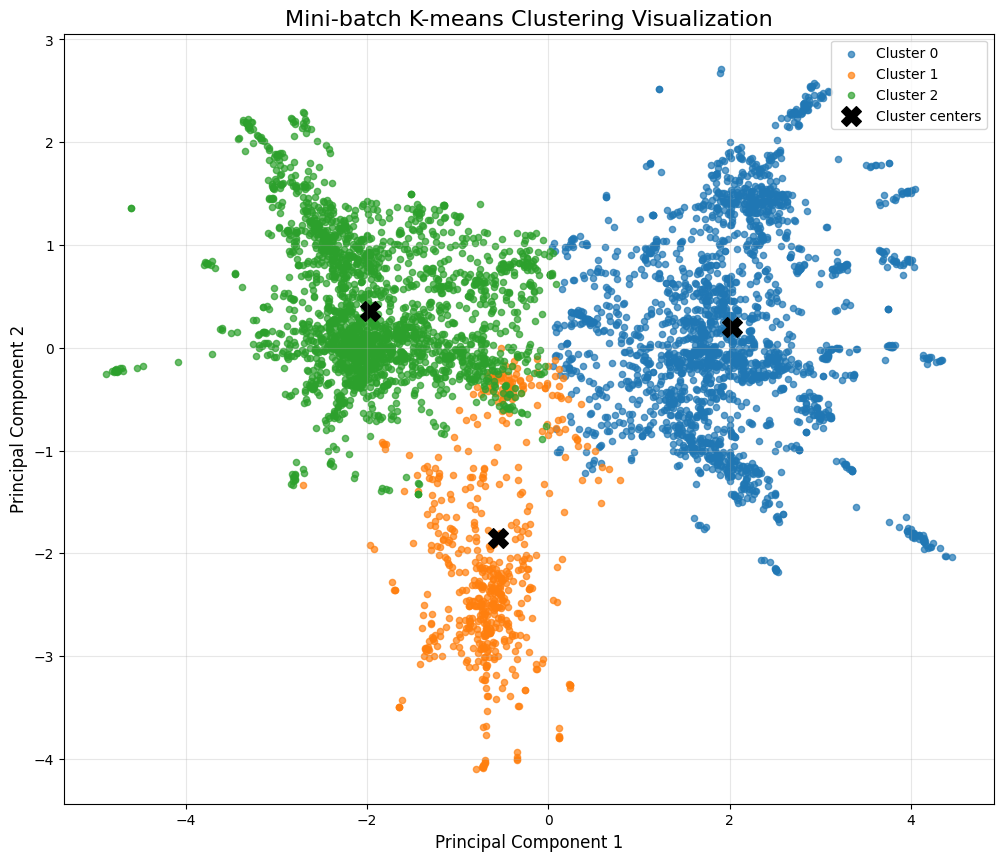

In [13]:
# Visualize clusters using PCA for final 2D representation
def visualize_clusters(embeddings, labels, centers=None, max_points=5000):
    print("Visualizing clusters...")
    start_time = time.time()

    # Sample data if too large
    if len(embeddings) > max_points:
        indices = np.random.choice(len(embeddings), max_points, replace=False)
        sample_embeddings = embeddings[indices]
        sample_labels = labels[indices]
    else:
        sample_embeddings = embeddings
        sample_labels = labels

    # Reduce to 2D for visualization using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(sample_embeddings)

    # Plot centers if provided
    if centers is not None:
        centers_2d = pca.transform(centers)

    # Create a scatter plot with custom colors
    plt.figure(figsize=(12, 10))

    # Define nice colors for the clusters
    colors = ['#2077B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

    # Plot points for each cluster
    for label in sorted(set(sample_labels)):
        mask = sample_labels == label
        plt.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=20,
            c=colors[label % len(colors)],
            alpha=0.7,
            label=f'Cluster {label}'
        )

    # Plot cluster centers if provided
    if centers is not None:
        plt.scatter(
            centers_2d[:, 0],
            centers_2d[:, 1],
            s=200,
            c='black',
            alpha=1.0,
            marker='X',
            label='Cluster centers'
        )

    plt.title('Mini-batch K-means Clustering Visualization', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)

    print(f"Visualization completed in {time.time() - start_time:.2f} seconds")
    plt.show()

# Visualize the clusters
visualize_clusters(reduced_embeddings, cluster_labels, cluster_centers)

Analyzing clusters in relation to true sentiment labels...

Cluster 0 analysis (22513 samples):
Bullish: 13797 samples (61.28%)
Neutral: 5132 samples (22.80%)
Bearish: 3584 samples (15.92%)
Dominant sentiment: Bullish (61.28%)

Cluster 1 analysis (5761 samples):
Bullish: 3395 samples (58.93%)
Neutral: 1341 samples (23.28%)
Bearish: 1025 samples (17.79%)
Dominant sentiment: Bullish (58.93%)

Cluster 2 analysis (20418 samples):
Bullish: 12084 samples (59.18%)
Neutral: 3856 samples (18.89%)
Bearish: 4478 samples (21.93%)
Dominant sentiment: Bullish (59.18%)

Adjusted Rand Index: 0.0044
Normalized Mutual Information: 0.0033


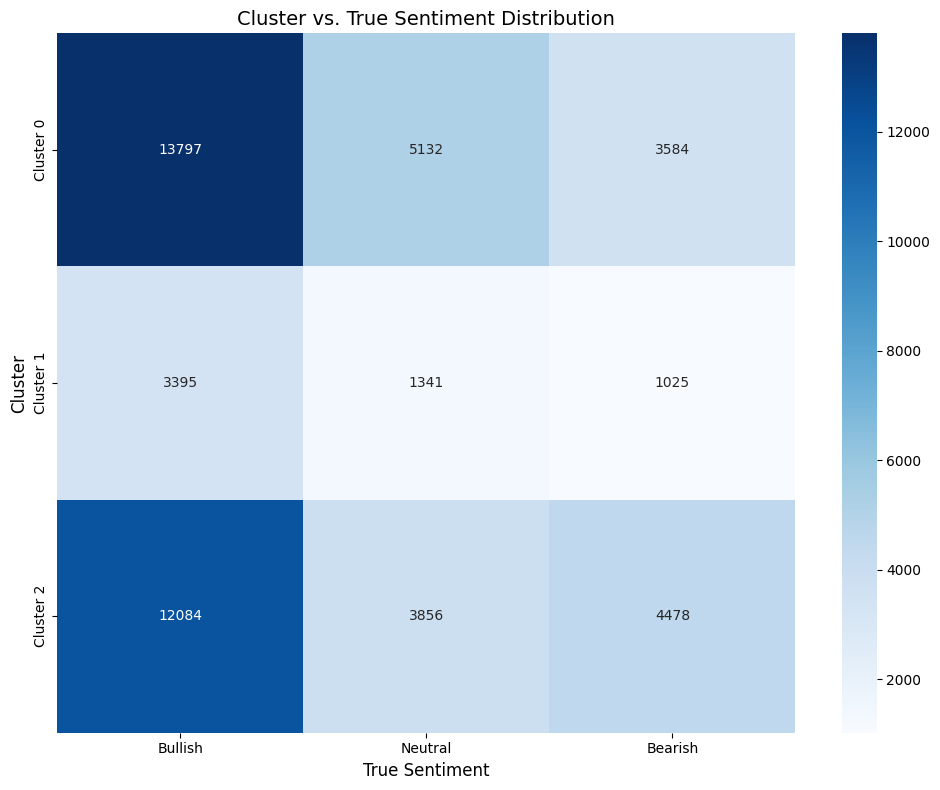


Proposed cluster-to-sentiment mapping:
Cluster 0 → Bullish
Cluster 1 → Bullish
Cluster 2 → Bullish


In [14]:
# Analyze clusters in relation to true sentiment labels
def analyze_clusters(cluster_labels, true_labels):
    print("Analyzing clusters in relation to true sentiment labels...")

    # Convert true_labels to numpy array for easier manipulation
    true_labels = np.array(true_labels)

    # Define sentiment names for readability
    sentiment_names = {0: "Bullish", 1: "Neutral", 2: "Bearish"}

    # Analyze each cluster
    clusters = sorted(set(cluster_labels))

    # Create a confusion matrix-like structure
    conf_matrix = np.zeros((len(clusters), len(sentiment_names)), dtype=int)

    for cluster in clusters:
        # Get indices of tweets in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get the true sentiments for these tweets
        cluster_true_sentiments = true_labels[cluster_indices]

        # Count sentiment distribution
        sentiment_counts = Counter(cluster_true_sentiments)
        total = len(cluster_indices)

        print(f"\nCluster {cluster} analysis ({total} samples):")
        for sentiment, count in sorted(sentiment_counts.items()):
            conf_matrix[cluster, sentiment] = count
            print(f"{sentiment_names[sentiment]}: {count} samples ({count/total*100:.2f}%)")

        # Find the dominant sentiment
        dominant_sentiment = max(sentiment_counts.items(), key=lambda x: x[1])[0]
        dominant_percent = sentiment_counts[dominant_sentiment] / total * 100

        print(f"Dominant sentiment: {sentiment_names[dominant_sentiment]} ({dominant_percent:.2f}%)")

    # Calculate metrics
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"\nAdjusted Rand Index: {ari:.4f}")
    print(f"Normalized Mutual Information: {nmi:.4f}")

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[sentiment_names[i] for i in range(len(sentiment_names))],
        yticklabels=[f'Cluster {i}' for i in clusters]
    )
    plt.xlabel('True Sentiment', fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.title('Cluster vs. True Sentiment Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Attempt to map clusters to sentiments
    cluster_to_sentiment = {}
    for cluster in clusters:
        dominant_sentiment = np.argmax(conf_matrix[cluster])
        cluster_to_sentiment[cluster] = dominant_sentiment

    print("\nProposed cluster-to-sentiment mapping:")
    for cluster, sentiment in cluster_to_sentiment.items():
        print(f"Cluster {cluster} → {sentiment_names[sentiment]}")

    return cluster_to_sentiment

# Analyze clusters
cluster_to_sentiment = analyze_clusters(cluster_labels, true_labels)

In [15]:
# Implement Mini-batch K-means
def run_minibatch_kmeans(embeddings, n_clusters=6, batch_size=1024, random_state=42, n_init=10):
    print(f"Running Mini-batch K-means with {n_clusters} clusters...")
    start_time = time.time()

    # Initialize and fit the model
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        batch_size=batch_size,
        random_state=random_state,
        n_init=n_init,
        max_iter=1000  # Increase for better convergence
    )
    cluster_labels = mbk.fit_predict(embeddings)

    # Count samples in each cluster
    counter = Counter(cluster_labels)
    print("\nCluster distribution:")
    for cluster, count in sorted(counter.items()):
        print(f"Cluster {cluster}: {count} samples ({count/len(embeddings)*100:.2f}%)")

    # Calculate silhouette score
    silhouette = silhouette_score(embeddings, cluster_labels)
    print(f"Silhouette score: {silhouette:.4f}")

    print(f"Clustering completed in {time.time() - start_time:.2f} seconds")

    return cluster_labels, mbk.cluster_centers_

# Run Mini-batch K-means
cluster_labels, cluster_centers = run_minibatch_kmeans(reduced_embeddings)

Running Mini-batch K-means with 6 clusters...

Cluster distribution:
Cluster 0: 4460 samples (9.16%)
Cluster 1: 11732 samples (24.09%)
Cluster 2: 12021 samples (24.69%)
Cluster 3: 9487 samples (19.48%)
Cluster 4: 1125 samples (2.31%)
Cluster 5: 9867 samples (20.26%)
Silhouette score: 0.2436
Clustering completed in 70.70 seconds


Visualizing clusters...
Visualization completed in 0.16 seconds


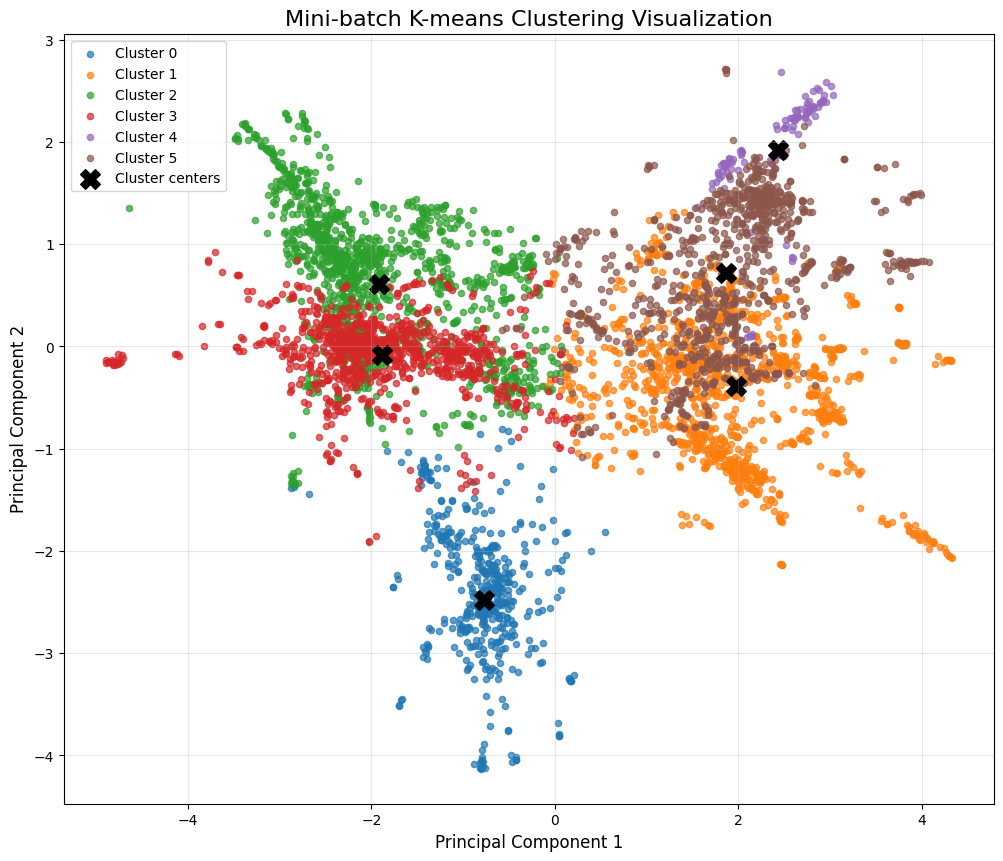

In [16]:
# Visualize clusters using PCA for final 2D representation
def visualize_clusters(embeddings, labels, centers=None, max_points=5000):
    print("Visualizing clusters...")
    start_time = time.time()

    # Sample data if too large
    if len(embeddings) > max_points:
        indices = np.random.choice(len(embeddings), max_points, replace=False)
        sample_embeddings = embeddings[indices]
        sample_labels = labels[indices]
    else:
        sample_embeddings = embeddings
        sample_labels = labels

    # Reduce to 2D for visualization using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(sample_embeddings)

    # Plot centers if provided
    if centers is not None:
        centers_2d = pca.transform(centers)

    # Create a scatter plot with custom colors
    plt.figure(figsize=(12, 10))

    # Define nice colors for the clusters
    colors = ['#2077B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

    # Plot points for each cluster
    for label in sorted(set(sample_labels)):
        mask = sample_labels == label
        plt.scatter(
            reduced_data[mask, 0],
            reduced_data[mask, 1],
            s=20,
            c=colors[label % len(colors)],
            alpha=0.7,
            label=f'Cluster {label}'
        )

    # Plot cluster centers if provided
    if centers is not None:
        plt.scatter(
            centers_2d[:, 0],
            centers_2d[:, 1],
            s=200,
            c='black',
            alpha=1.0,
            marker='X',
            label='Cluster centers'
        )

    plt.title('Mini-batch K-means Clustering Visualization', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)

    print(f"Visualization completed in {time.time() - start_time:.2f} seconds")
    plt.show()

# Visualize the clusters
visualize_clusters(reduced_embeddings, cluster_labels, cluster_centers)

Analyzing clusters in relation to true sentiment labels...

Cluster 0 analysis (4460 samples):
Bullish: 2526 samples (56.64%)
Neutral: 1167 samples (26.17%)
Bearish: 767 samples (17.20%)
Dominant sentiment: Bullish (56.64%)

Cluster 1 analysis (11732 samples):
Bullish: 7550 samples (64.35%)
Neutral: 2629 samples (22.41%)
Bearish: 1553 samples (13.24%)
Dominant sentiment: Bullish (64.35%)

Cluster 2 analysis (12021 samples):
Bullish: 7561 samples (62.90%)
Neutral: 1420 samples (11.81%)
Bearish: 3040 samples (25.29%)
Dominant sentiment: Bullish (62.90%)

Cluster 3 analysis (9487 samples):
Bullish: 5272 samples (55.57%)
Neutral: 2557 samples (26.95%)
Bearish: 1658 samples (17.48%)
Dominant sentiment: Bullish (55.57%)

Cluster 4 analysis (1125 samples):
Bullish: 662 samples (58.84%)
Neutral: 188 samples (16.71%)
Bearish: 275 samples (24.44%)
Dominant sentiment: Bullish (58.84%)

Cluster 5 analysis (9867 samples):
Bullish: 5705 samples (57.82%)
Neutral: 2368 samples (24.00%)
Bearish: 1794 s

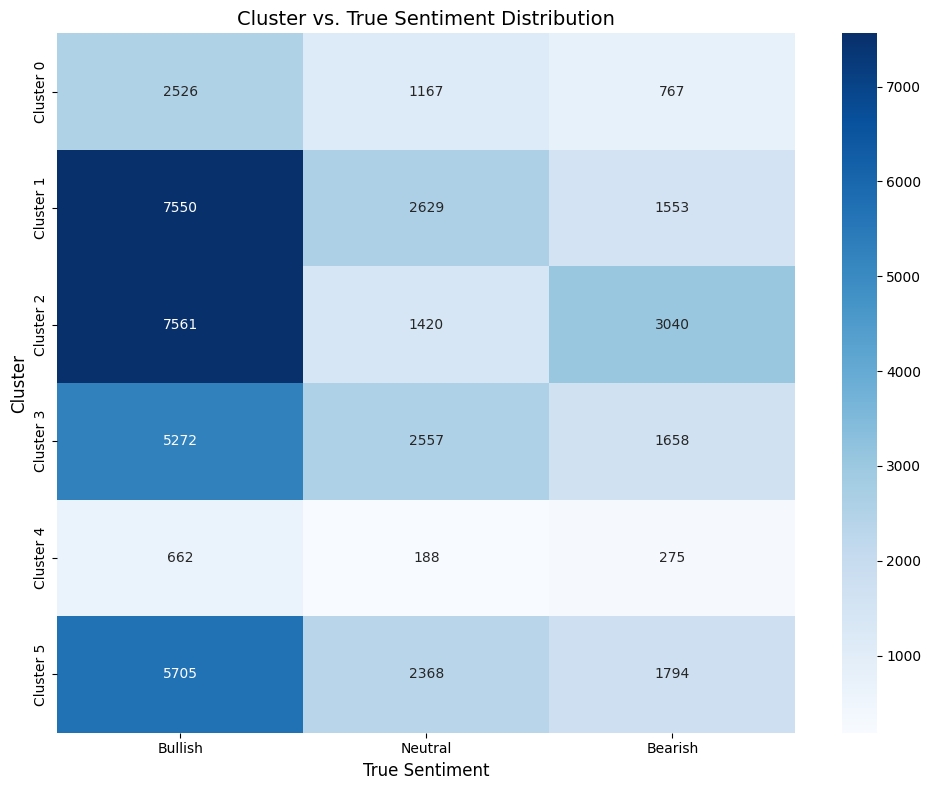


Proposed cluster-to-sentiment mapping:
Cluster 0 → Bullish
Cluster 1 → Bullish
Cluster 2 → Bullish
Cluster 3 → Bullish
Cluster 4 → Bullish
Cluster 5 → Bullish


In [17]:
# Analyze clusters in relation to true sentiment labels
def analyze_clusters(cluster_labels, true_labels):
    print("Analyzing clusters in relation to true sentiment labels...")

    # Convert true_labels to numpy array for easier manipulation
    true_labels = np.array(true_labels)

    # Define sentiment names for readability
    sentiment_names = {0: "Bullish", 1: "Neutral", 2: "Bearish"}

    # Analyze each cluster
    clusters = sorted(set(cluster_labels))

    # Create a confusion matrix-like structure
    conf_matrix = np.zeros((len(clusters), len(sentiment_names)), dtype=int)

    for cluster in clusters:
        # Get indices of tweets in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get the true sentiments for these tweets
        cluster_true_sentiments = true_labels[cluster_indices]

        # Count sentiment distribution
        sentiment_counts = Counter(cluster_true_sentiments)
        total = len(cluster_indices)

        print(f"\nCluster {cluster} analysis ({total} samples):")
        for sentiment, count in sorted(sentiment_counts.items()):
            conf_matrix[cluster, sentiment] = count
            print(f"{sentiment_names[sentiment]}: {count} samples ({count/total*100:.2f}%)")

        # Find the dominant sentiment
        dominant_sentiment = max(sentiment_counts.items(), key=lambda x: x[1])[0]
        dominant_percent = sentiment_counts[dominant_sentiment] / total * 100

        print(f"Dominant sentiment: {sentiment_names[dominant_sentiment]} ({dominant_percent:.2f}%)")

    # Calculate metrics
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"\nAdjusted Rand Index: {ari:.4f}")
    print(f"Normalized Mutual Information: {nmi:.4f}")

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[sentiment_names[i] for i in range(len(sentiment_names))],
        yticklabels=[f'Cluster {i}' for i in clusters]
    )
    plt.xlabel('True Sentiment', fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.title('Cluster vs. True Sentiment Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Attempt to map clusters to sentiments
    cluster_to_sentiment = {}
    for cluster in clusters:
        dominant_sentiment = np.argmax(conf_matrix[cluster])
        cluster_to_sentiment[cluster] = dominant_sentiment

    print("\nProposed cluster-to-sentiment mapping:")
    for cluster, sentiment in cluster_to_sentiment.items():
        print(f"Cluster {cluster} → {sentiment_names[sentiment]}")

    return cluster_to_sentiment

# Analyze clusters
cluster_to_sentiment = analyze_clusters(cluster_labels, true_labels)